In [2]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

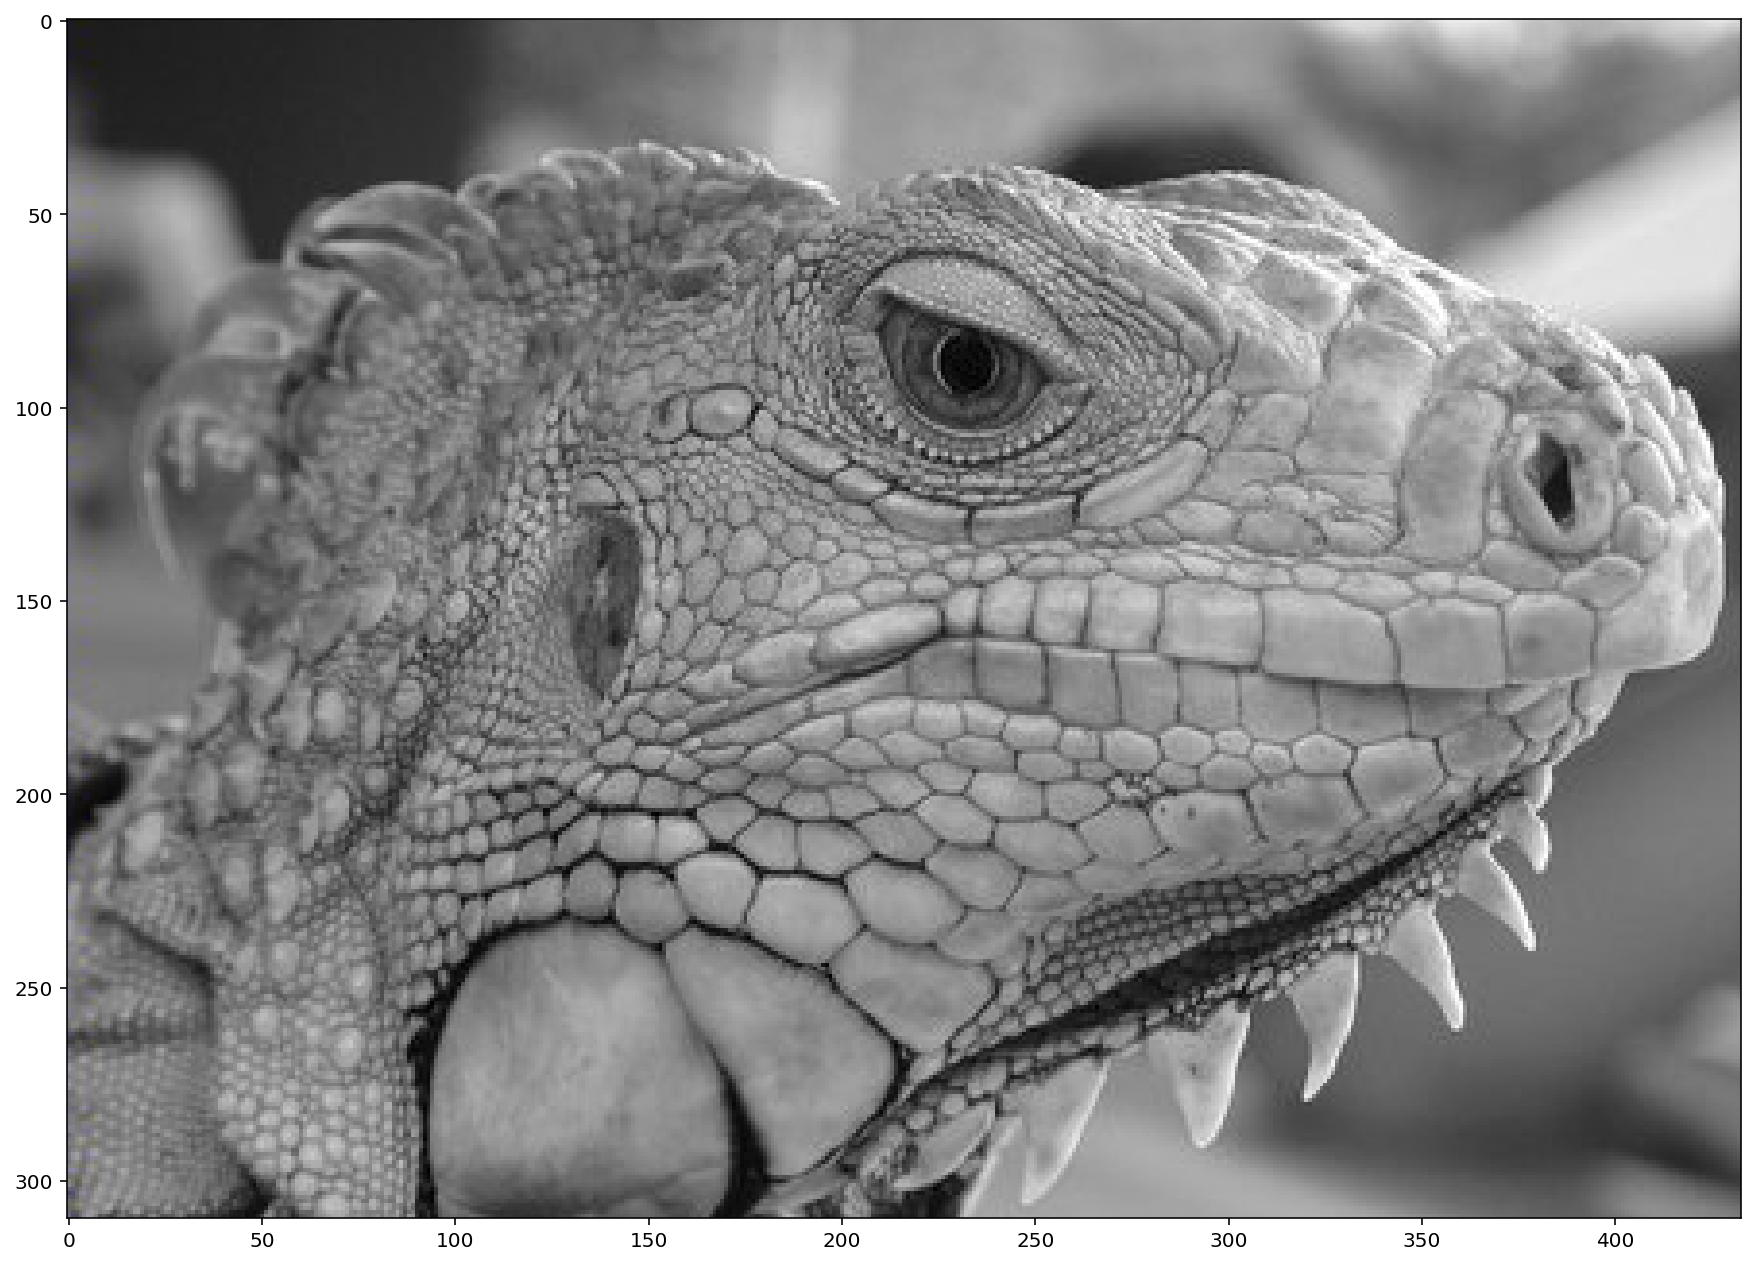

In [3]:
img = plt.imread('iguana.png')
plt.imshow(img)

In [4]:
sigma1 = sigma2 = 1
sum = 0

gaussian = np.zeros([5, 5])
for i in range(5):
    for j in range(5):
        gaussian[i, j] = math.exp(-1 / 2 * (np.square(i - 3) / np.square(sigma1)  # 生成二维高斯分布矩阵
                                            + (np.square(j - 3) / np.square(sigma2)))) / (2 * math.pi * sigma1 * sigma2)
        sum = sum + gaussian[i, j]

gaussian = gaussian / sum
gaussian

array([[2.21670366e-05, 2.70049789e-04, 1.21027919e-03, 1.99541304e-03,
        1.21027919e-03],
       [2.70049789e-04, 3.28987993e-03, 1.47442189e-02, 2.43091074e-02,
        1.47442189e-02],
       [1.21027919e-03, 1.47442189e-02, 6.60790048e-02, 1.08945861e-01,
        6.60790048e-02],
       [1.99541304e-03, 2.43091074e-02, 1.08945861e-01, 1.79621358e-01,
        1.08945861e-01],
       [1.21027919e-03, 1.47442189e-02, 6.60790048e-02, 1.08945861e-01,
        6.60790048e-02]])

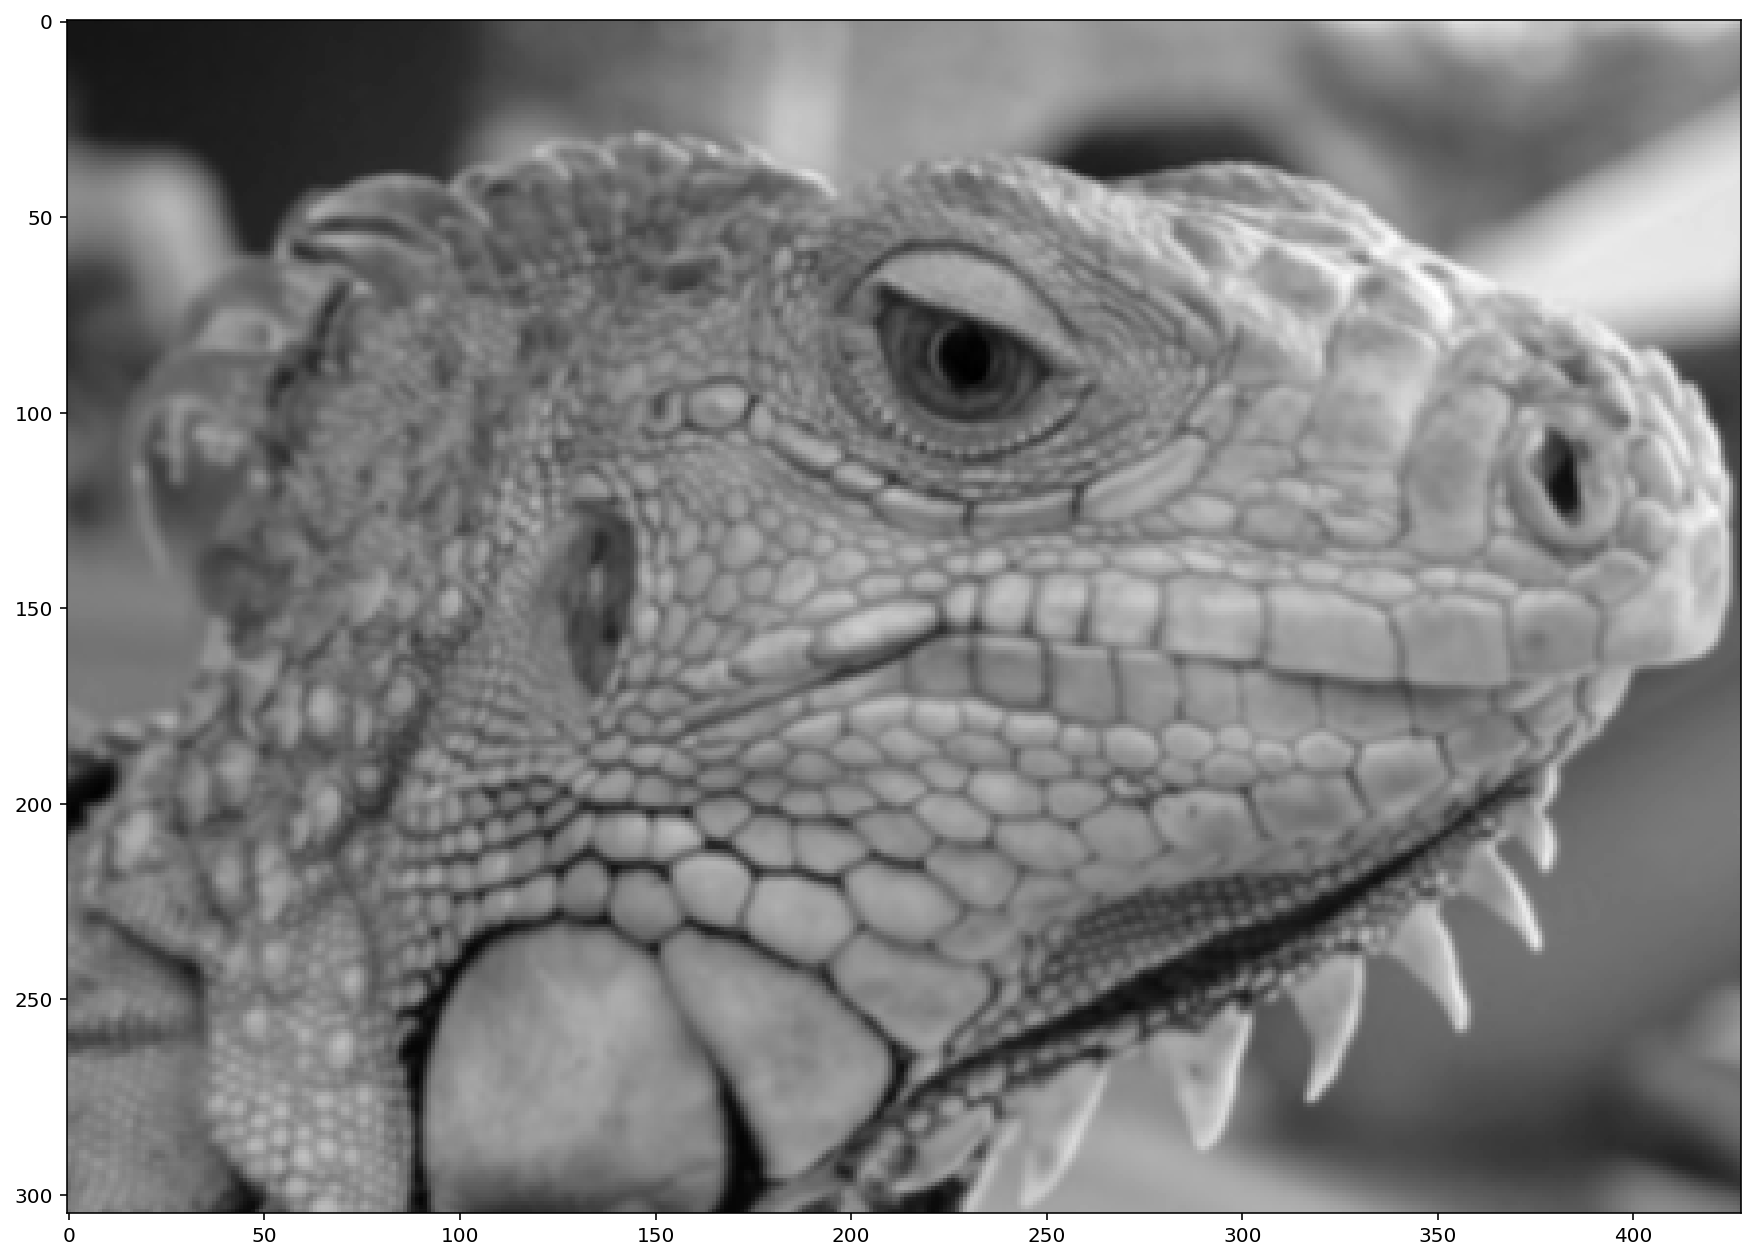

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


# step1.高斯滤波
gray = rgb2gray(img)
W, H = gray.shape
new_gray = np.zeros([W - 5, H - 5])
for i in range(W - 5):
    for j in range(H - 5):
        new_gray[i, j] = np.sum(gray[i:i + 5, j:j + 5] * gaussian)  # 与高斯矩阵卷积实现滤波

plt.imshow(new_gray, cmap="gray")

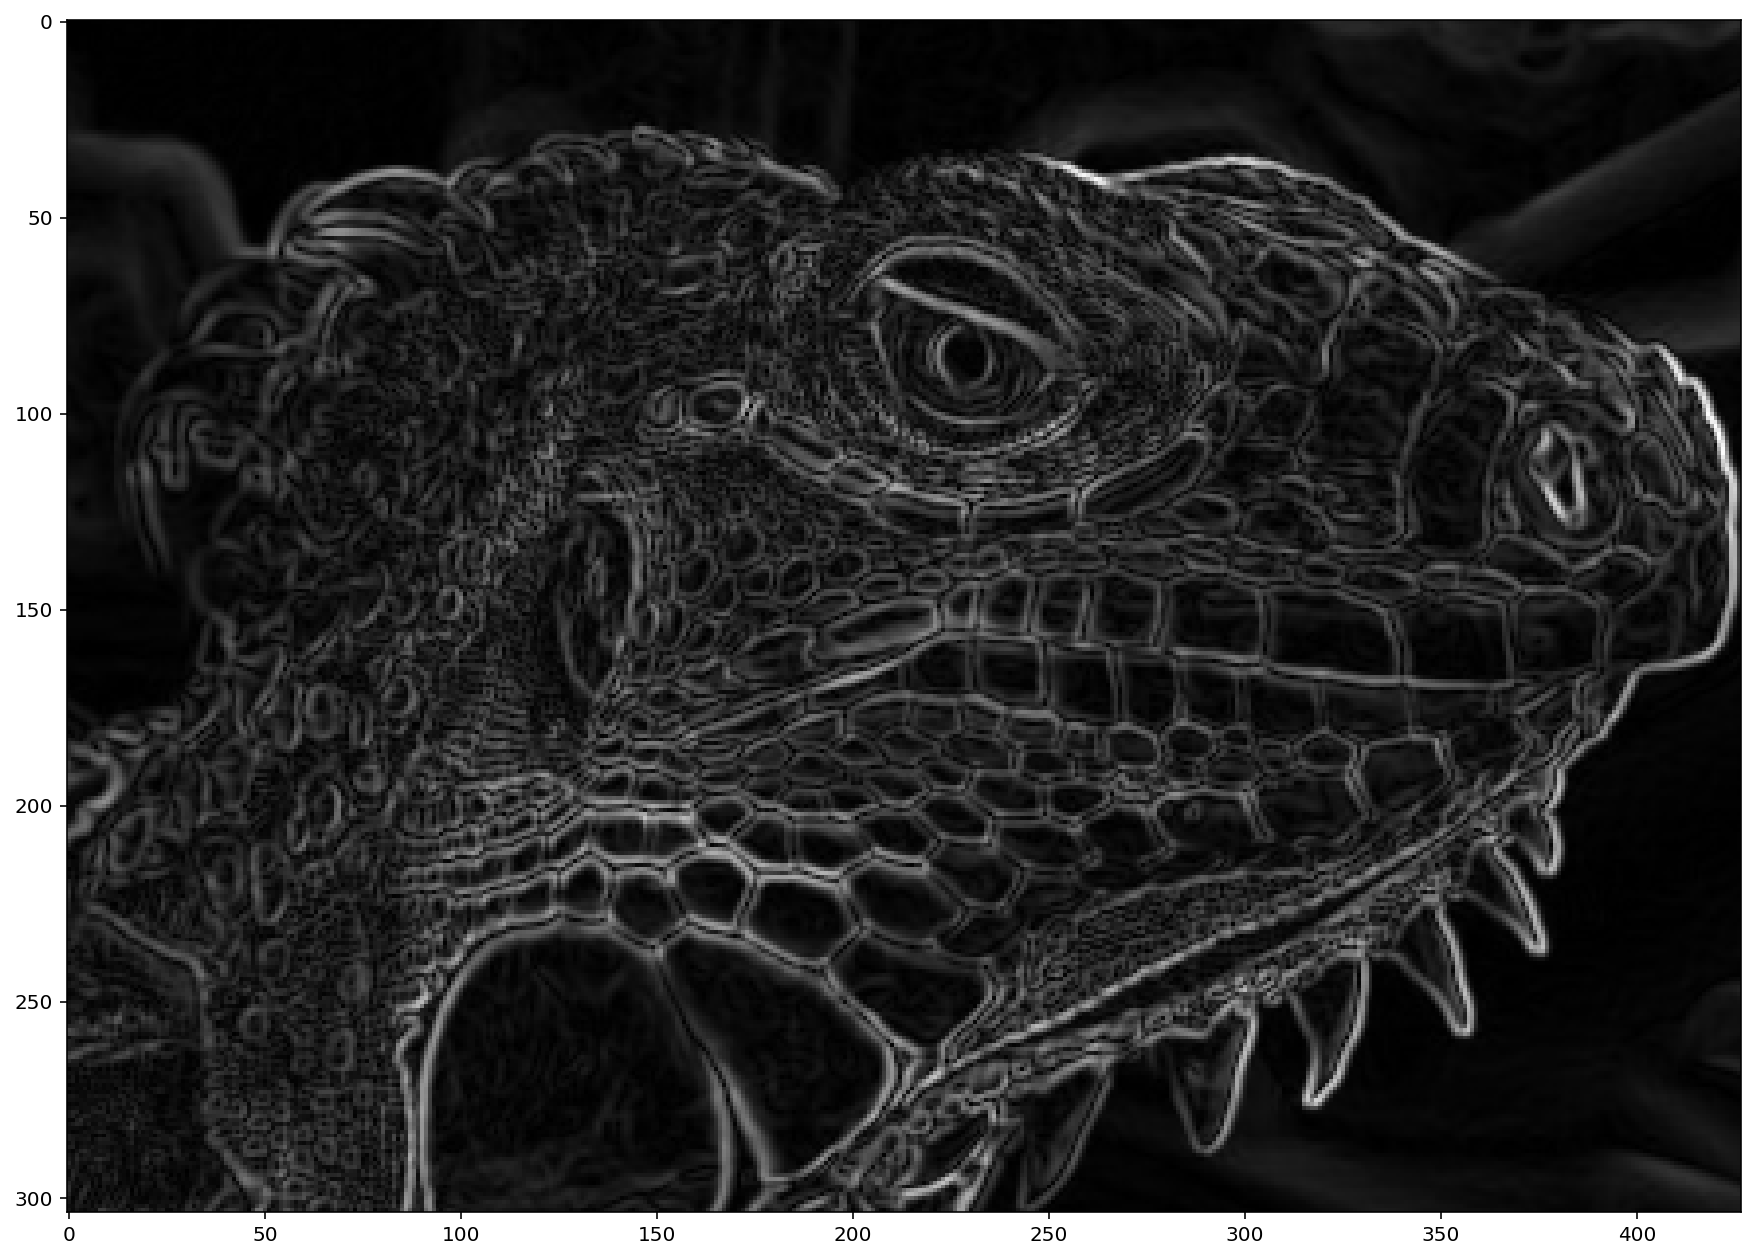

In [11]:
W1, H1 = new_gray.shape
dx = np.zeros([W1 - 1, H1 - 1])
dy = np.zeros([W1 - 1, H1 - 1])
d = np.zeros([W1 - 1, H1 - 1])
for i in range(W1 - 1):
    for j in range(H1 - 1):
        dx[i, j] = new_gray[i, j ] - new_gray[i, j+1]
        dy[i, j] = new_gray[i, j] - new_gray[i+1, j]
        d[i, j] = np.sqrt(np.square(dx[i, j]) + np.square(dy[i, j]))  # 图像梯度幅值作为图像强度值

plt.imshow(d, cmap="gray")

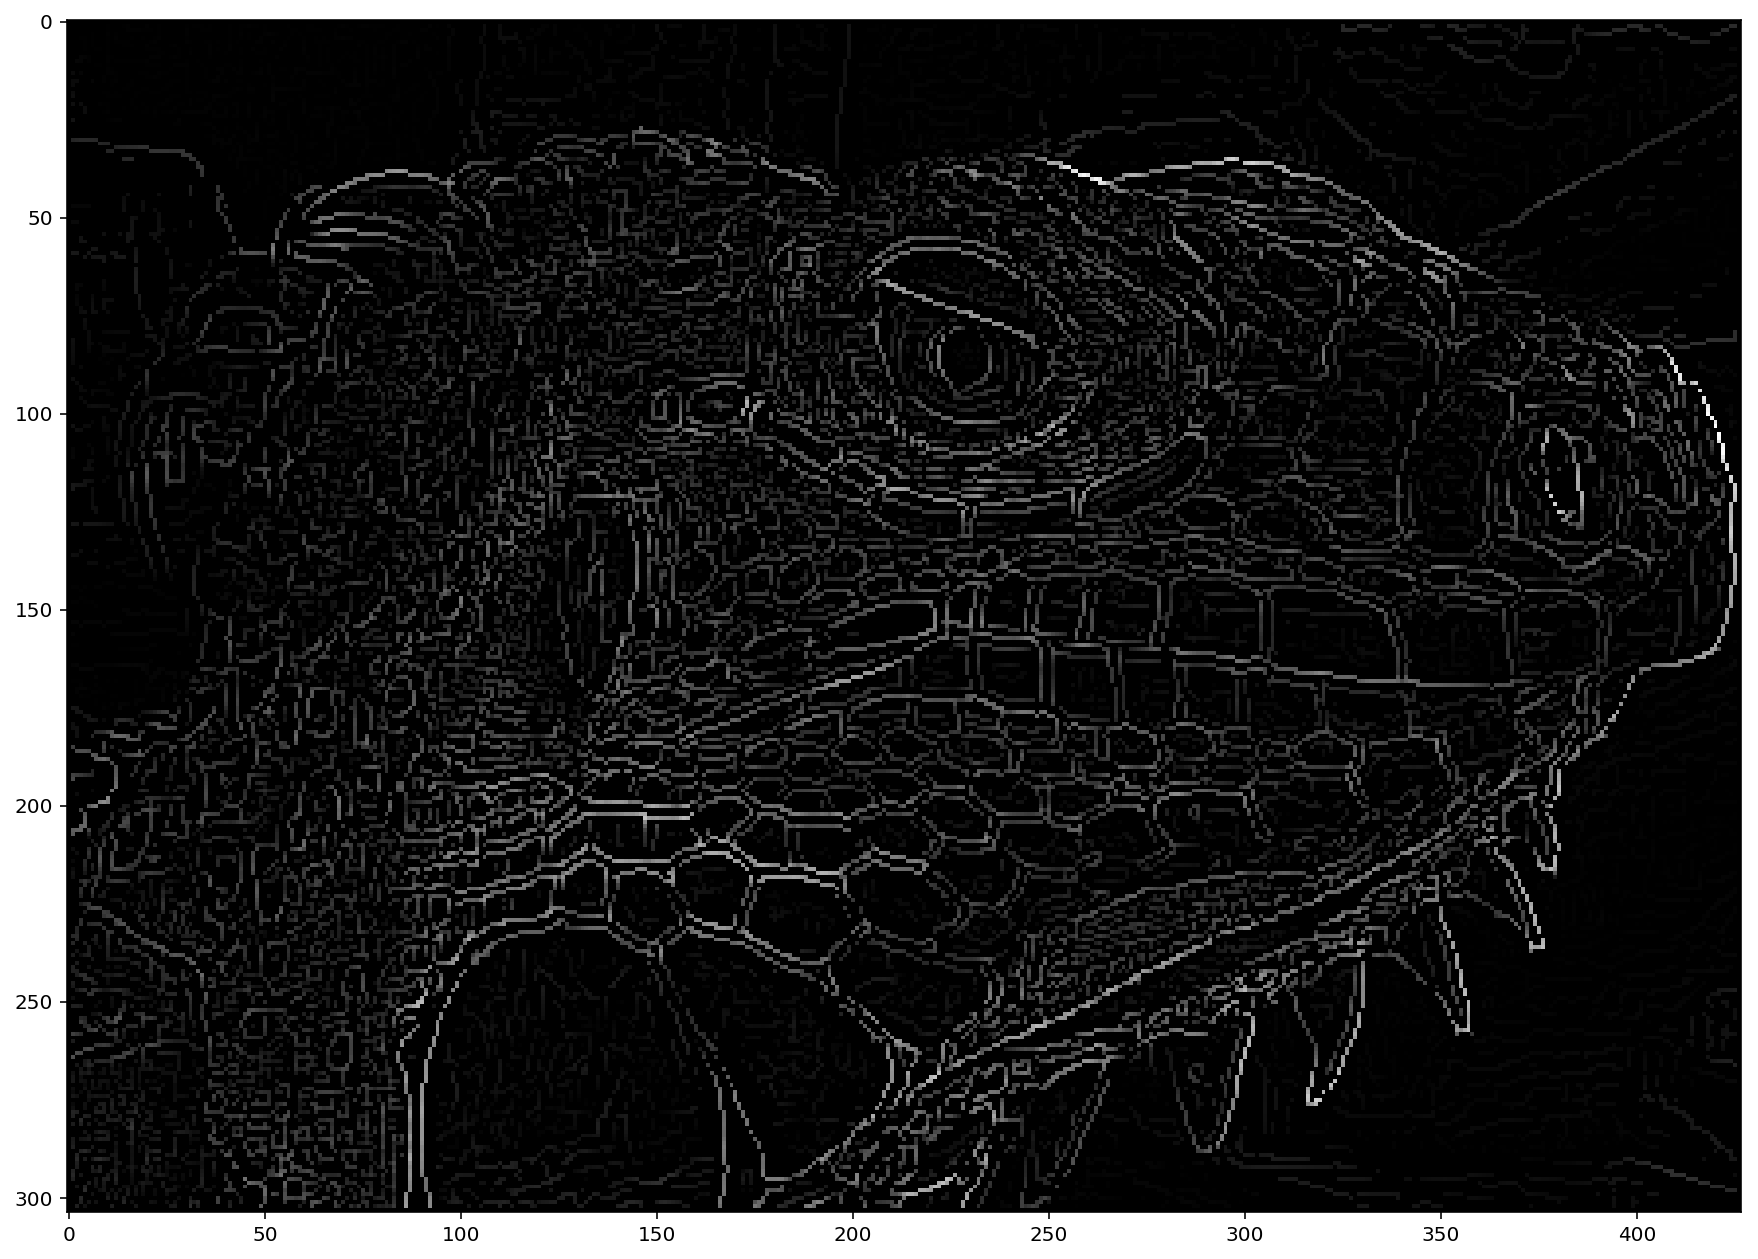

In [12]:
W2, H2 = d.shape
NMS = np.copy(d)
NMS[0, :] = NMS[W2 - 1, :] = NMS[:, 0] = NMS[:, H2 - 1] = 0
for i in range(1, W2 - 1):
    for j in range(1, H2 - 1):

        if d[i, j] == 0:
            NMS[i, j] = 0
        else:
            gradX = dx[i, j]
            gradY = dy[i, j]
            gradTemp = d[i, j]

            # 如果Y方向幅度值较大
            if np.abs(gradY) > np.abs(gradX):
                weight = np.abs(gradX) / np.abs(gradY)
                grad2 = d[i - 1, j]
                grad4 = d[i + 1, j]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i - 1, j - 1]
                    grad3 = d[i + 1, j + 1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i - 1, j + 1]
                    grad3 = d[i + 1, j - 1]

            # 如果X方向幅度值较大
            else:
                weight = np.abs(gradY) / np.abs(gradX)
                grad2 = d[i, j - 1]
                grad4 = d[i, j + 1]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i + 1, j - 1]
                    grad3 = d[i - 1, j + 1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i - 1, j - 1]
                    grad3 = d[i + 1, j + 1]

            gradTemp1 = weight * grad1 + (1 - weight) * grad2
            gradTemp2 = weight * grad3 + (1 - weight) * grad4
            if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                NMS[i, j] = gradTemp
            else:
                NMS[i, j] = 0

plt.imshow(NMS, cmap = "gray")

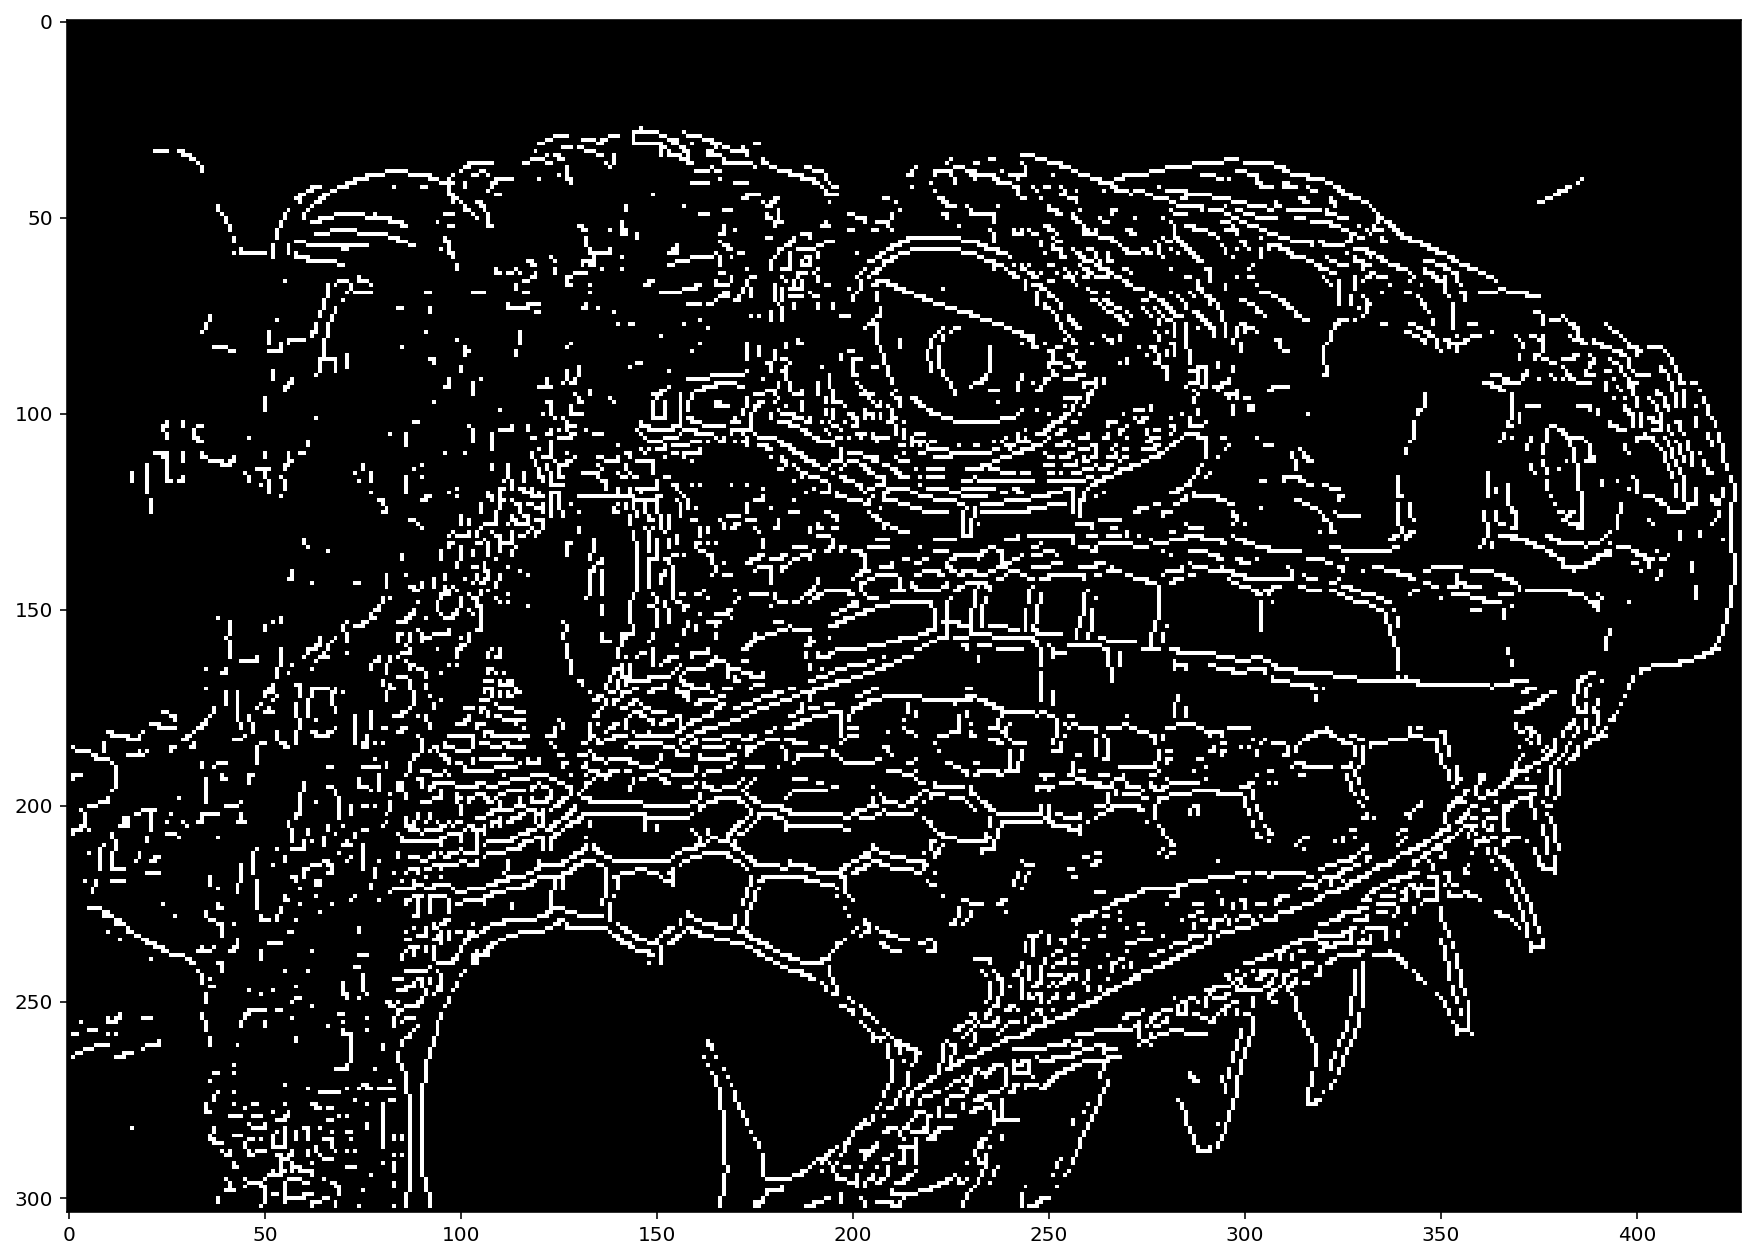

In [13]:
# step4. 双阈值算法检测、连接边缘
W3, H3 = NMS.shape
DT = np.zeros([W3, H3])
# 定义高低阈值
TL = 0.2 * np.max(NMS)
TH = 0.3 * np.max(NMS)
for i in range(1, W3 - 1):
    for j in range(1, H3 - 1):
        if (NMS[i, j] < TL):
            DT[i, j] = 0
        elif (NMS[i, j] > TH):
            DT[i, j] = 1
        elif ((NMS[i - 1, j - 1:j + 1] < TH).any() or (NMS[i + 1, j - 1:j + 1]).any()
              or (NMS[i, [j - 1, j + 1]] < TH).any()):
            DT[i, j] = 1

plt.imshow(DT, cmap="gray")